Titanic 生还者数据预测
===========
----------------------
主要按照以下几个步骤进行：<br>
1.导入数据<br>
2.数据初步处理<br>
3.数据相关性分析  
4.特征工程<br>
5.构建模型与数据训练<br>
6.结果预测<br>

---------------------------------------------------------------------

### 1.导入数据
---------------------------------------------------
* 导入初步处理需要的包
* 导入数据

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df=pd.read_csv(r'E:\Jupyter\Titanic all original data\train.csv')
test_df=pd.read_csv(r'E:\Jupyter\Titanic all original data\test.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


首先通过分析训练数据，发现部分数据缺失（Age，Cabin，Embarked，fare）。  
fare主要是在test数据中缺失，在train数据中是完整的。  
而且，Cabin数据在test数据中缺失数量明显多于train中数据  
因此，在进行特征工程前，有必要先进行数据的预处理工作

接下来整合数据，补充数据

### 2.数据初步处理
---------------------------------------------------------
* 对缺失的Age，Cabin，Embarked，Fare进行填充

In [3]:
'''
训练集和测试集数据合并
'''
df=train_df.append(test_df)
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [4]:
'''
实际的名字对分析并无没有用，
但是名字中间的称谓可以判断人物的身份及性别，所以提取出人物的称谓替代姓名
'''
df['Name']=df['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())

In [5]:
'''
查看分类后的姓名信息
'''
titles=df['Name'].unique()
titles

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


可见缺失的数据只有Age,Cabin,Embarked,Fare  
下面先对缺失的数据进行填充

##### 对年龄进行填充  
显然同一种身份的人年龄近似的可能性更大,因此取各个身份年龄的平均值，并将其填充至空值

In [7]:
for title in titles:
    median=df.Age[(df['Age'].isnull()==False)&(df['Name']==title)].median()
    df.Age[df['Age'].isnull()==True]=median

##### 对舱级进行填充
舱位这个数据对于分析成活率的意义不大且数据缺失不多,所以对于缺失的数据直接填充U（Unknow）

In [8]:
df['Cabin'].fillna('U',inplace=True)

##### 对登录位置（Embarked）进行填充
由于登录位置数据缺失较少，因此以概率最大的标签进行填充

In [9]:
df['Embarked'].fillna('S',inplace=True)
df['Embarked'].value_counts()

S    916
C    270
Q    123
Name: Embarked, dtype: int64

##### 对票价（Fare）进行填充
显然票价信息基本完整，
根据对数据观察的结果，可见票价与Pclass相关，显然等级高的票价高

In [10]:
for pclass in [1,2,3]:
    median=df.Fare[(df['Pclass']==pclass)&(df['Fare'].isnull()==False)].median()
    df.Fare[df['Fare'].isnull()==True]=median

### 3.数据相关性分析
---------------------------------------------------
* 可视化分析数据相关性

In [11]:
'''
为了便于分析规律，将数据完整的df
分成train_Df和test_Df两个文件
'''
train_Df=df[0:890]
test_Df=df[891:]

plcass与存活率的关系

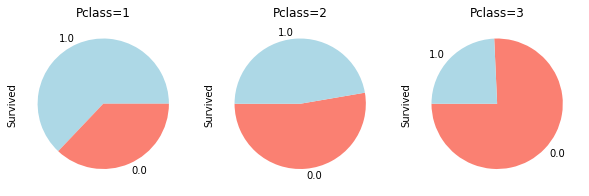

In [12]:
fig = plt.figure(figsize=(10,3))
colors=['salmon', 'lightblue', 'y']
colors1=['lightblue','salmon', 'y']
fig.add_subplot(131)
train_Df.Survived[train_Df['Pclass'] == 1].value_counts().plot(kind='pie',colors=colors1,title='Pclass=1')
fig.add_subplot(132)
train_Df.Survived[train_Df['Pclass'] == 2].value_counts().plot(kind='pie',colors=colors,startangle=180,title='Pclass=2')
fig.add_subplot(133)
train_Df.Survived[train_Df['Pclass'] == 3].value_counts().plot(kind='pie',colors=colors,startangle=180,title='Pclass=3')

称谓与存活率的关系

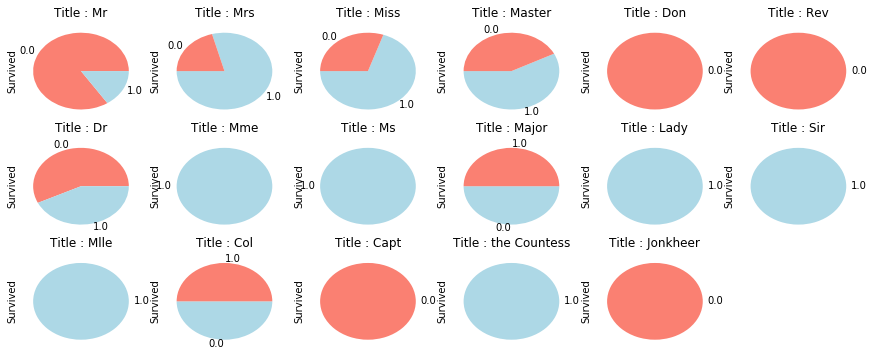

In [13]:
fig = plt.figure(figsize=(15,6))
colors=['salmon', 'lightblue', 'y']
colors1=['lightblue','salmon', 'y']
i=1
for title in train_Df['Name'].unique():
    fig.add_subplot(3, 6, i)
    plt.title('Title : {}'.format(title))
    dat=train_Df.Survived[train_Df['Name'] == title].value_counts()
    try:
        if dat[0] and dat[0]>dat[1]:
                col=colors
                ang=0
        else:
                col=colors1
                ang=180
    except:
        if 1 in dat:
            col=colors1
        else:
           col=colors
    train_Df.Survived[train_Df['Name'] == title].value_counts().plot(kind='pie',colors=col,startangle=ang)
    i += 1

性别与存活率的关系

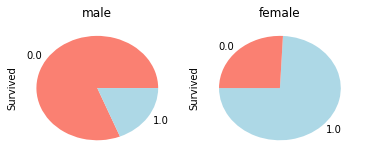

In [14]:
fig = plt.figure(figsize=(6,2.4))
colors=['salmon', 'lightblue', 'y']
colors1=['lightblue','salmon', 'y']
fig.add_subplot(121)
train_Df.Survived[train_Df['Sex'] == 'male'].value_counts().plot(kind='pie',colors=colors,title='male')
fig.add_subplot(122)
train_Df.Survived[train_Df['Sex'] == 'female'].value_counts().plot(kind='pie',colors=colors1,startangle=180,title='female')

年龄与存活率关系

In [15]:
'''
年龄数据由于过于离散，因此这里使用qcut将其划分成5个区间段
'''
train_Df['AgeBin']=pd.qcut(train_Df['Age'],6)
train_Df['AgeBin'].unique()

[(19.0, 25.0], (31.0, 40.5], (25.0, 29.0], (40.5, 80.0], (0.419, 19.0], (29.0, 31.0]]
Categories (6, interval[float64]): [(0.419, 19.0] < (19.0, 25.0] < (25.0, 29.0] < (29.0, 31.0] < (31.0, 40.5] < (40.5, 80.0]]

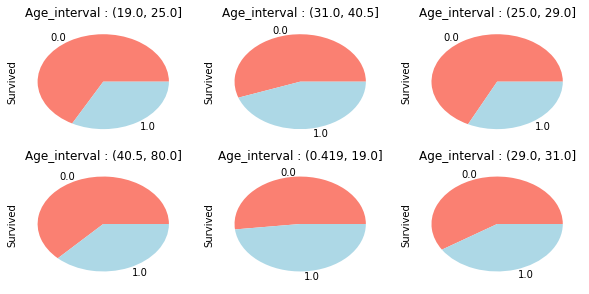

In [16]:
fig = plt.figure(figsize=(10,4.8))
colors=['salmon', 'lightblue', 'y']
colors1=['lightblue','salmon', 'y']
i=1
for title in train_Df['AgeBin'].unique():
    fig.add_subplot(2, 3, i)
    plt.title('Age_interval : {}'.format(title))
    dat=train_Df.Survived[train_Df['AgeBin'] == title].value_counts()
    try:
        if dat[0] and dat[0]>dat[1]:
                col=colors
                ang=0
        else:
                col=colors1
                ang=180
    except:
        if 1 in dat:
            col=colors1
        else:
           col=colors
    train_Df.Survived[train_Df['AgeBin'] == title].value_counts().plot(kind='pie',colors=col,startangle=ang)
    i += 1

登录点与存活率关系

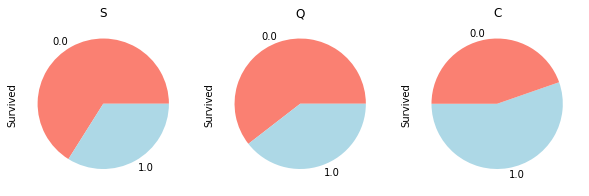

In [17]:
'''
出发地点：S=英国南安普顿Southampton
途径地点1：C=法国 瑟堡市Cherbourg
途径地点2：Q=爱尔兰 昆士敦Queenstown
'''
fig = plt.figure(figsize=(10,3))
colors=['salmon', 'lightblue', 'y']
colors1=['lightblue','salmon', 'y']
fig.add_subplot(131)
train_Df.Survived[train_Df['Embarked'] == 'S'].value_counts().plot(kind='pie',colors=colors,title='S')
fig.add_subplot(132)
train_Df.Survived[train_Df['Embarked'] == 'Q'].value_counts().plot(kind='pie',colors=colors,startangle=0,title='Q')
fig.add_subplot(133)
train_Df.Survived[train_Df['Embarked'] == 'C'].value_counts().plot(kind='pie',colors=colors1,startangle=180,title='C')

### 4.特征工程
---------------------------------------------------
* 对字符串型数据进行分析，并将其数字化
* 对数字过于离散的数据进行分析，并划分区间
* 部分数据在查看过相关性后，决定是否保留

对性别进行数字化

In [18]:
'''
将男性赋值为1，女性赋值为0，并查看赋值后的结果
'''
sex={'male':1,'female':0}
df['Sex']=df['Sex'].map(sex)
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,U,S,7.2500,Mr,0,1,3,1,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,Mrs,0,2,1,0,1,1.0,PC 17599
2,26.0,U,S,7.9250,Miss,0,3,3,0,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,Mrs,0,4,1,0,1,1.0,113803
4,35.0,U,S,8.0500,Mr,0,5,3,1,0,0.0,373450


数字化登船港口

In [19]:
'''
由于登船位置转换为数字后，最大为3，这明显高于性别的1
因此在分类过程中，得到的分类器结果完全有可能认为登船位置有更高的权重
而这显然是错误的，因此很有必要对数据进行标准化
'''
from sklearn.preprocessing import StandardScaler,LabelEncoder
checkin={'S':1,'Q':2,'C':3}
df['Embarked']=df['Embarked'].map(checkin)
df['Embarked'] = StandardScaler().fit_transform(df['Embarked'].values.reshape(-1, 1))

名称数据分类并数据化

In [20]:
'''
先对称谓进行归类，
然后进行数字化
'''
mapping = {'Don': 'Mr','Dona': 'Mrs','Mlle': 'Miss', 'Major': 'Officer', 'Col': 'Officer',
           'Sir': 'Mr',  'Mme': 'Mrs', 'Jonkheer': 'nobility', 'Lady': 'Mrs', 'Capt': 'Mr',
           'the Countess': 'nobility', 'Ms': 'Mrs', 'Rev':'Mr',
           'Master':'Officer','Dr':'Officer'}
df['Name'].replace(mapping, inplace=True)
label={'Mr':1,'Miss':2,'Mrs':3,'Officer':4,'nobility':5}
df['Name']=df['Name'].map(label)
df['Name'] = StandardScaler().fit_transform(df['Name'].values.reshape(-1, 1))

下面是数值型数据  
年龄数据过于离散，因此将其按照区间进行划分

In [21]:
'''
根据数据特征，利用cut进行如下分类
0-20岁，少年
20-40岁,青壮年
40-60岁，中年
60-80岁，老年
但是，由于最后使用逻辑回归属性不可以为标签，所以结果用labelEncoder进行编码
'''
from sklearn.preprocessing import LabelEncoder
df['AgeBin']=pd.cut(df['Age'],4)
df['AgeBin'].head()

0    (20.128, 40.085]
1    (20.128, 40.085]
2    (20.128, 40.085]
3    (20.128, 40.085]
4    (20.128, 40.085]
Name: AgeBin, dtype: category
Categories (4, interval[float64]): [(0.0902, 20.128] < (20.128, 40.085] < (40.085, 60.043] < (60.043, 80.0]]

In [22]:
df['AgeBin']=LabelEncoder().fit_transform(df['AgeBin'])
df['AgeBin']=StandardScaler().fit_transform(df['AgeBin'].values.reshape(-1, 1))

对家庭规模进行整合

In [23]:
df['Family_size']=df['SibSp']+df['Parch']
df['Family_size']=StandardScaler().fit_transform(df['Family_size'].values.reshape(-1, 1))

船票费用过于离散，因此这里进行区间划分

In [24]:
df.Fare[df['Pclass']==1].describe()

count    323.000000
mean      87.508992
std       80.447178
min        0.000000
25%       30.695800
50%       60.000000
75%      107.662500
max      512.329200
Name: Fare, dtype: float64

In [25]:
df['Fare'].describe()

count    1309.000000
mean       33.315880
std        51.744144
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [26]:
'''
按照船费情况，将人员的阶层进行划分
'''
bins=[-1,102,250,515]
df['FareBin']=pd.cut(df['Fare'],bins)
df['FareBin'].unique()

[(-1, 102], (250, 515], (102, 250]]
Categories (3, interval[int64]): [(-1, 102] < (102, 250] < (250, 515]]

In [27]:
df['FareBin']=LabelEncoder().fit_transform(df['FareBin'])

In [28]:
df['FareBin']=StandardScaler().fit_transform(df['FareBin'].values.reshape(-1, 1))

In [29]:
'''
查看处理后的结果
'''
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,AgeBin,Family_size,FareBin
0,22.0,U,-0.622279,7.2500,-0.729691,0,1,3,1,1,0.0,A/5 21171,-0.013845,0.073352,-0.247512
1,38.0,C85,1.834926,71.2833,1.395261,0,2,1,0,1,1.0,PC 17599,-0.013845,0.073352,-0.247512
2,26.0,U,-0.622279,7.9250,0.332785,0,3,3,0,0,1.0,STON/O2. 3101282,-0.013845,-0.558346,-0.247512
3,35.0,C123,-0.622279,53.1000,1.395261,0,4,1,0,1,1.0,113803,-0.013845,0.073352,-0.247512
4,35.0,U,-0.622279,8.0500,-0.729691,0,5,3,1,0,0.0,373450,-0.013845,-0.558346,-0.247512


In [30]:
df1=df.copy()

In [31]:
df1.drop(['Parch','SibSp','Age','Ticket','Cabin','PassengerId'],1,inplace=True)

In [32]:
corr_Df=df1.corr()
corr_Df['Survived'].sort_values(ascending =False)

Survived       1.000000
Name           0.468935
Fare           0.257307
FareBin        0.175803
Embarked       0.167675
Family_size    0.016639
AgeBin        -0.066946
Pclass        -0.338481
Sex           -0.543351
Name: Survived, dtype: float64

### 5.构建模型与数据训练
---------------------------------------------------
* 先将train数据划分为训练集和测试集
* 用logistics_regression进行分类并查看分类结果

In [33]:
'''
导入建模模块
'''
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

D:\Program\Anaconda\envs\py3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
Df=df1[0:891]                             #切片选出之前train_data
pre_df=df1[891:].drop('Survived',axis=1)  #切片选出之前test_data,并删除Survived列
Survived=Df.loc[:,'Survived']            #测试结果单独提取出来
Df=Df.drop('Survived',axis=1)            #原数据中删除Survived数据

In [35]:
X_train, X_test, y_train, y_test = train_test_split(Df, Survived, test_size=0.2,random_state = 11)

In [36]:
model=LogisticRegression()

In [37]:
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
model.score(X_test,y_test)

0.87709497206703912

### 6.结果预测
---------------------------------------------------
* 基于当前的训练模型对test数据的结果进行预测

In [39]:
'''
生成的预测值是浮点数（0.0,1,0）
但是Kaggle要求提交的结果是整型（0,1）
所以要对数据类型进行转换
'''
pre_y=model.predict(pre_df)
#由于生成的是浮点型数据，而Kaggle需要的结果是整形，因此先对数据进行转换
pre_y=pre_y.astype(int)
#将乘客id与预测结果整合到一个Df中
passenger_id = df.PassengerId[891:]
predDf = pd.DataFrame( 
    { 'PassengerId': passenger_id , 
     'Survived': pre_y } )

In [40]:
#保存结果
predDf.to_csv(r'E:\Jupyter\Titanic all original data\titanic_pred.csv' , index = False )